In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import euclidemu2
import scipy
import cosmolike_lsst_y1_interface as ci
from getdist import IniFile
print(sys.version)
print(os.getcwd())

# GENERAL PLOT OPTIONS
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['xtick.bottom'] = True
matplotlib.rcParams['xtick.top'] = False
matplotlib.rcParams['ytick.right'] = False
matplotlib.rcParams['axes.edgecolor'] = 'black'
matplotlib.rcParams['axes.linewidth'] = '1.0'
matplotlib.rcParams['axes.labelsize'] = 'medium'
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['grid.linewidth'] = '0.0'
matplotlib.rcParams['grid.alpha'] = '0.18'
matplotlib.rcParams['grid.color'] = 'lightgray'
matplotlib.rcParams['legend.labelspacing'] = 0.77
matplotlib.rcParams['savefig.bbox'] = 'tight'
matplotlib.rcParams['savefig.format'] = 'pdf'
matplotlib.rcParams['text.usetex'] = True


Classy could not be found in your system.
Here are some suggestions:

	 -Download the Class from class-code.net and install it
	  together with its wrapper classy (type 'make' instead of
	  'make class'
	 -If you know that Class is installed on your system
	  and yet classy could not be installed, try re-compiling
	  Class with just ''make'' instead of ''make class''
NOTICE: Even without classy you can still use EuclidEmulator2
        to emulate boost factors. You won't be able to compute
        full power spectra, though.
3.9.19 | packaged by conda-forge | (main, Mar 20 2024, 12:50:21) 
[GCC 12.3.0]
/home/vivianmiranda/extra_data/Vivian/Cocoa2024/cocoa/Cocoa/projects/lsst_y1


In [2]:
# IMPORT CAMB
sys.path.insert(0, os.environ['ROOTDIR']+'/external_modules/code/CAMB/build/lib.linux-x86_64-'+os.environ['PYTHON_VERSION'])
import camb
from camb import model
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.5.5 installed at /home/vivianmiranda/extra_data/Vivian/Cocoa2024/cocoa/Cocoa/external_modules/code/CAMB/build/lib.linux-x86_64-3.9/camb


In [3]:
CAMBAccuracyBoost = 1.1
kmax = 10*CAMBAccuracyBoost
extrap_kmax = 2.5e2 * CAMBAccuracyBoost
k_per_logint = 20
non_linear_emul = 2

CLAccuracyBoost = 1.0
CLSamplingBoost = 1.0
CLIntegrationAccuracy = 1
CLprobe="xi"

path= "../../external_modules/data/lsst_y1"
data_file="LSST_Y1_M1_GGL0.05.dataset"

IA_model = 0
IA_redshift_evolution = 3

In [4]:
As_1e9 = 2.1
ns = 0.96605
H0 = 67.32
omegab = 0.04
omegam = 0.3
mnu = 0.06
LSST_DZ_S1 = 0.0414632
LSST_DZ_S2 = 0.00147332
LSST_DZ_S3 = 0.0237035
LSST_DZ_S4 = -0.0773436
LSST_DZ_S5 = -8.67127e-05
LSST_M1 = 0.0191832
LSST_M2 = -0.0431752
LSST_M3 = -0.034961
LSST_M4 = -0.0158096
LSST_M5 = -0.0158096
LSST_A1_1 = 0.606102
LSST_A1_2 = -1.51541
w0pwa = -0.9
w = -0.9

In [5]:
As = lambda As_1e9: 1e-9 * As_1e9
wa = lambda w0pwa, w: w0pwa - w
omegabh2 = lambda omegab, H0: omegab*(H0/100)**2
omegach2 = lambda omegam, omegab, mnu, H0: (omegam-omegab)*(H0/100)**2-(mnu*(3.046/3)**0.75)/94.0708
omegamh2 = lambda omegam, H0: omegam*(H0/100)**2

## Let's compute $\chi^2_{LSST}$ and reproduce the results shown on EXAMPLE_EVALUATE1.YAML

In [6]:
pars = camb.set_params(
    H0=H0, 
    ombh2=omegabh2(omegab, H0), 
    omch2=omegach2(omegam, omegab, mnu, H0), 
    mnu=mnu, 
    omk=0, 
    tau=0.06,  
    As=As(As_1e9), 
    ns=ns, 
    halofit_version='takahashi', 
    lmax=10,
    AccuracyBoost=CAMBAccuracyBoost,
    lens_potential_accuracy=1.0,
    num_massive_neutrinos=1,
    nnu=3.046,
    accurate_massive_neutrino_transfers=False,
    k_per_logint=k_per_logint
);
pars.set_dark_energy(w=w, wa=wa(w0pwa, w), dark_energy_model='ppf');

In [7]:
# Compute Matter Power Spectrum - Here the code is a bit more complicated because 
# we want to allow nonlinear boost to be computed from Euclid Emulator v2.0.

z_interp_2D = np.concatenate((np.linspace(0, 2.0, 95), np.linspace(2.25, 10, 5)), axis=0)

log10k_interp_2D = np.linspace(-4.2, 2.0, 1200)

pars.NonLinear = model.NonLinear_both

pars.set_matter_power(redshifts=z_interp_2D, kmax=kmax * CAMBAccuracyBoost, silent=True);

results = camb.get_results(pars)

PKL  = results.get_matter_power_interpolator(
    var1="delta_tot", 
    var2="delta_tot", 
    nonlinear = False, 
    extrap_kmax = extrap_kmax, 
    hubble_units = False, 
    k_hunit = False
);

PKNL = results.get_matter_power_interpolator(    
    var1="delta_tot", 
    var2="delta_tot",  
    nonlinear = True, 
    extrap_kmax = extrap_kmax, 
    hubble_units = False, 
    k_hunit = False
);

lnPL  = np.empty(len(log10k_interp_2D)*len(z_interp_2D))

for i in range(len(z_interp_2D)):
    lnPL[i::len(z_interp_2D)] = np.log(
        PKL.P(z_interp_2D[i], np.power(10.0, log10k_interp_2D))
    )

lnPL  += np.log(((H0/100.)**3))

lnPNL  = np.empty(len(log10k_interp_2D)*len(z_interp_2D))

if non_linear_emul == 1:

    params = {
        'Omm'  : omegam,
        'As'   : As(As_1e9),
        'Omb'  : omegab,
        'ns'   : ns,
        'h'    : H0/100.,
        'mnu'  : mnu, 
        'w'    : w,
        'wa'   : wa(w0pwa, w)
    }

    kbt, bt = euclidemu2.get_boost(
        params, 
        z_interp_2D, 
        np.power(10.0, np.linspace(-2.0589, 0.973, len(log10k_interp_2D)))
    )

    log10k_interp_2D = log10k_interp_2D - np.log10(H0/100.)
    
    for i in range(len(z_interp_2D)):    
        lnbt = scipy.interpolate.interp1d(
            np.log10(kbt), 
            np.log(bt[i]), 
            kind = 'linear', 
            fill_value = 'extrapolate', 
            assume_sorted = True
        )(log10k_interp_2D)
        
        lnbt[np.power(10,log10k_interp_2D) < 8.73e-3] = 0.0
        
        lnPNL[i::len(z_interp_2D)]  = lnPL[i::len(z_interp_2D)] + lnbt

elif non_linear_emul == 2:

    for i in range(len(z_interp_2D)):
        lnPNL[i::len(z_interp_2D)] = np.log(PKNL.P(z_interp_2D[i], np.power(10.0, log10k_interp_2D)))
        
    log10k_interp_2D = log10k_interp_2D - np.log10(H0/100.)
    lnPNL += np.log(((H0/100.)**3))

In [8]:
# Compute Growth Factor
G_growth = np.sqrt(PKL.P(z_interp_2D,0.0005)/PKL.P(0,0.0005))
G_growth = G_growth*(1 + z_interp_2D)/G_growth[len(G_growth)-1]

In [9]:
# Compute Distances
z_interp_1D = np.concatenate((
    np.concatenate((np.linspace(0,2.0,1000), np.linspace(2.0,10.1,200)),axis=0),
    np.linspace(1080,2000,20)),axis=0) 

chi = results.comoving_radial_distance(z_interp_1D, tol=1e-4) * (H0/100.)

In [10]:
# Read LSST-Y1 data file
ini = IniFile(os.path.normpath(os.path.join(path, data_file)))
data_vector_file = ini.relativeFileName('data_file')
cov_file = ini.relativeFileName('cov_file')
mask_file = ini.relativeFileName('mask_file')
lens_file = ini.relativeFileName('nz_lens_file')
source_file = ini.relativeFileName('nz_source_file')
lens_ntomo = ini.int("lens_ntomo")
source_ntomo = ini.int("source_ntomo")
ntheta = ini.int("n_theta")
theta_min_arcmin = ini.float("theta_min_arcmin")
theta_max_arcmin = ini.float("theta_max_arcmin")

In [11]:
# Init Cosmolike
ci.initial_setup()
ci.init_accuracy_boost(CLAccuracyBoost, CLSamplingBoost, int(CLIntegrationAccuracy))
ci.init_probes(possible_probes=CLprobe)
ci.init_binning(int(ntheta), theta_min_arcmin, theta_max_arcmin)
ci.init_cosmo_runmode(is_linear=False)

[2024-08-19 20:03:35.687] [info] init_probes: Begins
[2024-08-19 20:03:35.687] [info] init_probes: possible_probes = xi selected
[2024-08-19 20:03:35.687] [info] init_probes: Ends
[2024-08-19 20:03:35.687] [info] init_binning_real_space: Begins
[2024-08-19 20:03:35.687] [info] init_binning_real_space: Ntheta = 26 selected.
[2024-08-19 20:03:35.687] [info] init_binning_real_space: theta_min_arcmin = 2.5 selected.
[2024-08-19 20:03:35.687] [info] init_binning_real_space: theta_max_arcmin = 900 selected.
[2024-08-19 20:03:35.687] [info] init_binning_real_space: Bin 0 - theta_min [rad] = 7.2722e-04, theta [rad] = 8.2307e-04 and theta_max [rad] = 9.1198e-04
[2024-08-19 20:03:35.687] [info] init_binning_real_space: Bin 1 - theta_min [rad] = 9.1198e-04, theta [rad] = 1.0322e-03 and theta_max [rad] = 1.1437e-03
[2024-08-19 20:03:35.687] [info] init_binning_real_space: Bin 2 - theta_min [rad] = 1.1437e-03, theta [rad] = 1.2944e-03 and theta_max [rad] = 1.4342e-03
[2024-08-19 20:03:35.687] [info

In [12]:
ci.set_cosmological_parameters(omega_matter = omegam, hubble = H0, is_cached = False)
ci.init_linear_power_spectrum(log10k = log10k_interp_2D, z = z_interp_2D, lnP = lnPL)
ci.init_non_linear_power_spectrum(log10k = log10k_interp_2D, z = z_interp_2D, lnP = lnPNL)
ci.init_growth(z = z_interp_2D, G = G_growth)
ci.init_distances(z = z_interp_1D, chi = chi) 

ci.init_IA(ia_model = int(IA_model), ia_redshift_evolution = int(IA_redshift_evolution))

ci.init_source_sample(filename=source_file, ntomo_bins=int(source_ntomo))
ci.init_lens_sample(filename=lens_file, ntomo_bins=int(lens_ntomo))
ci.init_data_real(cov_file, mask_file, data_vector_file)

ci.set_nuisance_shear_calib(M=[LSST_M1, LSST_M2, LSST_M3, LSST_M4, LSST_M5])
ci.set_nuisance_shear_photoz(bias=[LSST_DZ_S1, LSST_DZ_S2, LSST_DZ_S3, LSST_DZ_S4, LSST_DZ_S5])
ci.set_nuisance_ia(A1=[LSST_A1_1, LSST_A1_2, 0, 0, 0], A2=[0,0,0,0,0], B_TA=[0,0,0,0,0])

[2024-08-19 20:03:35.718] [info] init_IA: IA MODEL = 0 selected.
[2024-08-19 20:03:35.718] [info] init_source_sample: Begins
[2024-08-19 20:03:35.718] [info] init_source_sample: tomo.shear_Npowerspectra = 15
[2024-08-19 20:03:35.738] [info] init_source_sample: bin 0 - <z_s> = 0.3308314854665221.
[2024-08-19 20:03:35.738] [info] init_source_sample: bin 1 - <z_s> = 0.5361725588449201.
[2024-08-19 20:03:35.738] [info] init_source_sample: bin 2 - <z_s> = 0.7423499882523072.
[2024-08-19 20:03:35.738] [info] init_source_sample: bin 3 - <z_s> = 1.0109024147438441.
[2024-08-19 20:03:35.738] [info] init_source_sample: bin 4 - <z_s> = 1.6215849575215955.
[2024-08-19 20:03:35.738] [info] init_source_sample: shear_REDSHIFT_FILE = ../../external_modules/data/lsst_y1/source_LSSTY1.nz selected.
[2024-08-19 20:03:35.738] [info] init_source_sample: shear_Nbin = 5 selected.
[2024-08-19 20:03:35.738] [info] init_source_sample: Ends
[2024-08-19 20:03:35.739] [info] init_lens_sample: Begins
[2024-08-19 20:

[2024-08-19 20:03:35] [info] /home/vivianmiranda/extra_data/Vivian/Cocoa2024/cocoa/Cocoa/external_modules/code/cosmolike/redshift_spline.c:1016: tomo.shear_zmin[0] = 0.006,tomo.shear_zmax[0] = 0.741
[2024-08-19 20:03:35] [info] /home/vivianmiranda/extra_data/Vivian/Cocoa2024/cocoa/Cocoa/external_modules/code/cosmolike/redshift_spline.c:1016: tomo.shear_zmin[1] = 0.123,tomo.shear_zmax[1] = 0.998
[2024-08-19 20:03:35] [info] /home/vivianmiranda/extra_data/Vivian/Cocoa2024/cocoa/Cocoa/external_modules/code/cosmolike/redshift_spline.c:1016: tomo.shear_zmin[2] = 0.274,tomo.shear_zmax[2] = 1.324
[2024-08-19 20:03:35] [info] /home/vivianmiranda/extra_data/Vivian/Cocoa2024/cocoa/Cocoa/external_modules/code/cosmolike/redshift_spline.c:1016: tomo.shear_zmin[3] = 0.438,tomo.shear_zmax[3] = 1.674
[2024-08-19 20:03:35] [info] /home/vivianmiranda/extra_data/Vivian/Cocoa2024/cocoa/Cocoa/external_modules/code/cosmolike/redshift_spline.c:1016: tomo.shear_zmin[4] = 0.729,tomo.shear_zmax[4] = 3.494
[2024

In [13]:
# Compute chi2 - just to check we can reproduce EXAMPLE_EVALUATE1.yaml
datavector = np.array(ci.compute_data_vector_masked())
print(-0.5 * ci.compute_chi2(datavector))

-0.10719492257879948


# Lets see how cosmological parameters affect $C_{\ell}^{EE}$

In [14]:
def fCSS(ll, omegam, omegab, H0, ns, As_1e9, w, w0pwa):
    pars = camb.set_params(
        H0=H0, 
        ombh2=omegabh2(omegab, H0), 
        omch2=omegach2(omegam, omegab, mnu, H0), 
        mnu=mnu, 
        omk=0, 
        tau=0.06,  
        As=As(As_1e9), 
        ns=ns, 
        halofit_version='takahashi', 
        lmax=10,
        AccuracyBoost=CAMBAccuracyBoost,
        lens_potential_accuracy=1.0,
        num_massive_neutrinos=1,
        nnu=3.046,
        accurate_massive_neutrino_transfers=False,
        k_per_logint=k_per_logint
    );
    
    pars.set_dark_energy(w=w, wa=wa(w0pwa, w), dark_energy_model='ppf');

    z_interp_2D = np.concatenate((np.linspace(0, 2.0, 95), np.linspace(2.25, 10, 5)), axis=0)
    log10k_interp_2D = np.linspace(-4.2, 2.0, 1200)
    
    pars.NonLinear = model.NonLinear_both
    pars.set_matter_power(redshifts=z_interp_2D, kmax=kmax * CAMBAccuracyBoost, silent=True);

    results = camb.get_results(pars)
    
    PKL  = results.get_matter_power_interpolator(
        var1="delta_tot", 
        var2="delta_tot", 
        nonlinear = False, 
        extrap_kmax = extrap_kmax, 
        hubble_units = False, 
        k_hunit = False
    );

    PKNL = results.get_matter_power_interpolator(    
        var1="delta_tot", 
        var2="delta_tot",  
        nonlinear = True, 
        extrap_kmax = extrap_kmax, 
        hubble_units = False, 
        k_hunit = False
    );

    lnPL  = np.empty(len(log10k_interp_2D)*len(z_interp_2D))

    for i in range(len(z_interp_2D)):
        lnPL[i::len(z_interp_2D)] = np.log(
            PKL.P(z_interp_2D[i], np.power(10.0, log10k_interp_2D))
        )
        
    lnPL  += np.log(((H0/100.)**3))    
    lnPNL  = np.empty(len(log10k_interp_2D)*len(z_interp_2D))

    if non_linear_emul == 1:
        params = {'Omm'  : omegam, 'As'   : As(As_1e9), 'Omb'  : omegab,
            'ns'   : ns, 'h'    : H0/100., 'mnu'  : mnu,  'w'    : w, 'wa'   : wa(w0pwa, w)}
    
        kbt, bt = euclidemu2.get_boost(params, z_interp_2D, 
            np.power(10.0, np.linspace(-2.0589, 0.973, len(log10k_interp_2D))))
    
        log10k_interp_2D = log10k_interp_2D - np.log10(H0/100.)
        
        for i in range(len(z_interp_2D)):    
            lnbt = scipy.interpolate.interp1d(
                np.log10(kbt), 
                np.log(bt[i]), 
                kind = 'linear', 
                fill_value = 'extrapolate', 
                assume_sorted = True
            )(log10k_interp_2D)
            lnbt[np.power(10,log10k_interp_2D) < 8.73e-3] = 0.0
            lnPNL[i::len(z_interp_2D)]  = lnPL[i::len(z_interp_2D)] + lnbt
    elif non_linear_emul == 2:
        for i in range(len(z_interp_2D)):
            lnPNL[i::len(z_interp_2D)] = np.log(PKNL.P(z_interp_2D[i], np.power(10.0, log10k_interp_2D)))
            
        log10k_interp_2D = log10k_interp_2D - np.log10(H0/100.)
        lnPNL += np.log(((H0/100.)**3))

    G_growth = np.sqrt(PKL.P(z_interp_2D,0.0005)/PKL.P(0,0.0005))
    G_growth = G_growth*(1 + z_interp_2D)/G_growth[len(G_growth)-1]

    ci.set_nuisance_shear_calib(M=[LSST_M1, LSST_M2, LSST_M3, LSST_M4, LSST_M5])
    ci.set_nuisance_shear_photoz(bias=[LSST_DZ_S1, LSST_DZ_S2, LSST_DZ_S3, LSST_DZ_S4, LSST_DZ_S5])
    ci.set_nuisance_ia(A1=[LSST_A1_1, LSST_A1_2, 0, 0, 0], A2=[0,0,0,0,0], B_TA=[0,0,0,0,0])

    chi = results.comoving_radial_distance(z_interp_1D, tol=1e-4) * (H0/100.)
    ci.set_cosmological_parameters(omega_matter = omegam, hubble = H0, is_cached = False)
    ci.init_linear_power_spectrum(log10k = log10k_interp_2D, z = z_interp_2D, lnP = lnPL)
    ci.init_non_linear_power_spectrum(log10k = log10k_interp_2D, z = z_interp_2D, lnP = lnPNL)
    ci.init_growth(z = z_interp_2D, G = G_growth)
    ci.init_distances(z = z_interp_1D, chi = chi)

    (CSS, tmp) = ci.C_ss_tomo_limber(l=ll)
    return CSS

In [15]:
# Reference Cosmology
As_1e9 = 2.1
ns = 0.96605
H0 = 67.32
omegab = 0.04
omegam = 0.3
mnu = 0.06
LSST_DZ_S1 = 0.0414632
LSST_DZ_S2 = 0.00147332
LSST_DZ_S3 = 0.0237035
LSST_DZ_S4 = -0.0773436
LSST_DZ_S5 = -8.67127e-05
LSST_M1 = 0.0191832
LSST_M2 = -0.0431752
LSST_M3 = -0.034961
LSST_M4 = -0.0158096
LSST_M5 = -0.0158096
LSST_A1_1 = 0.606102
LSST_A1_2 = -1.51541
w0pwa = -0.9
w = -0.9

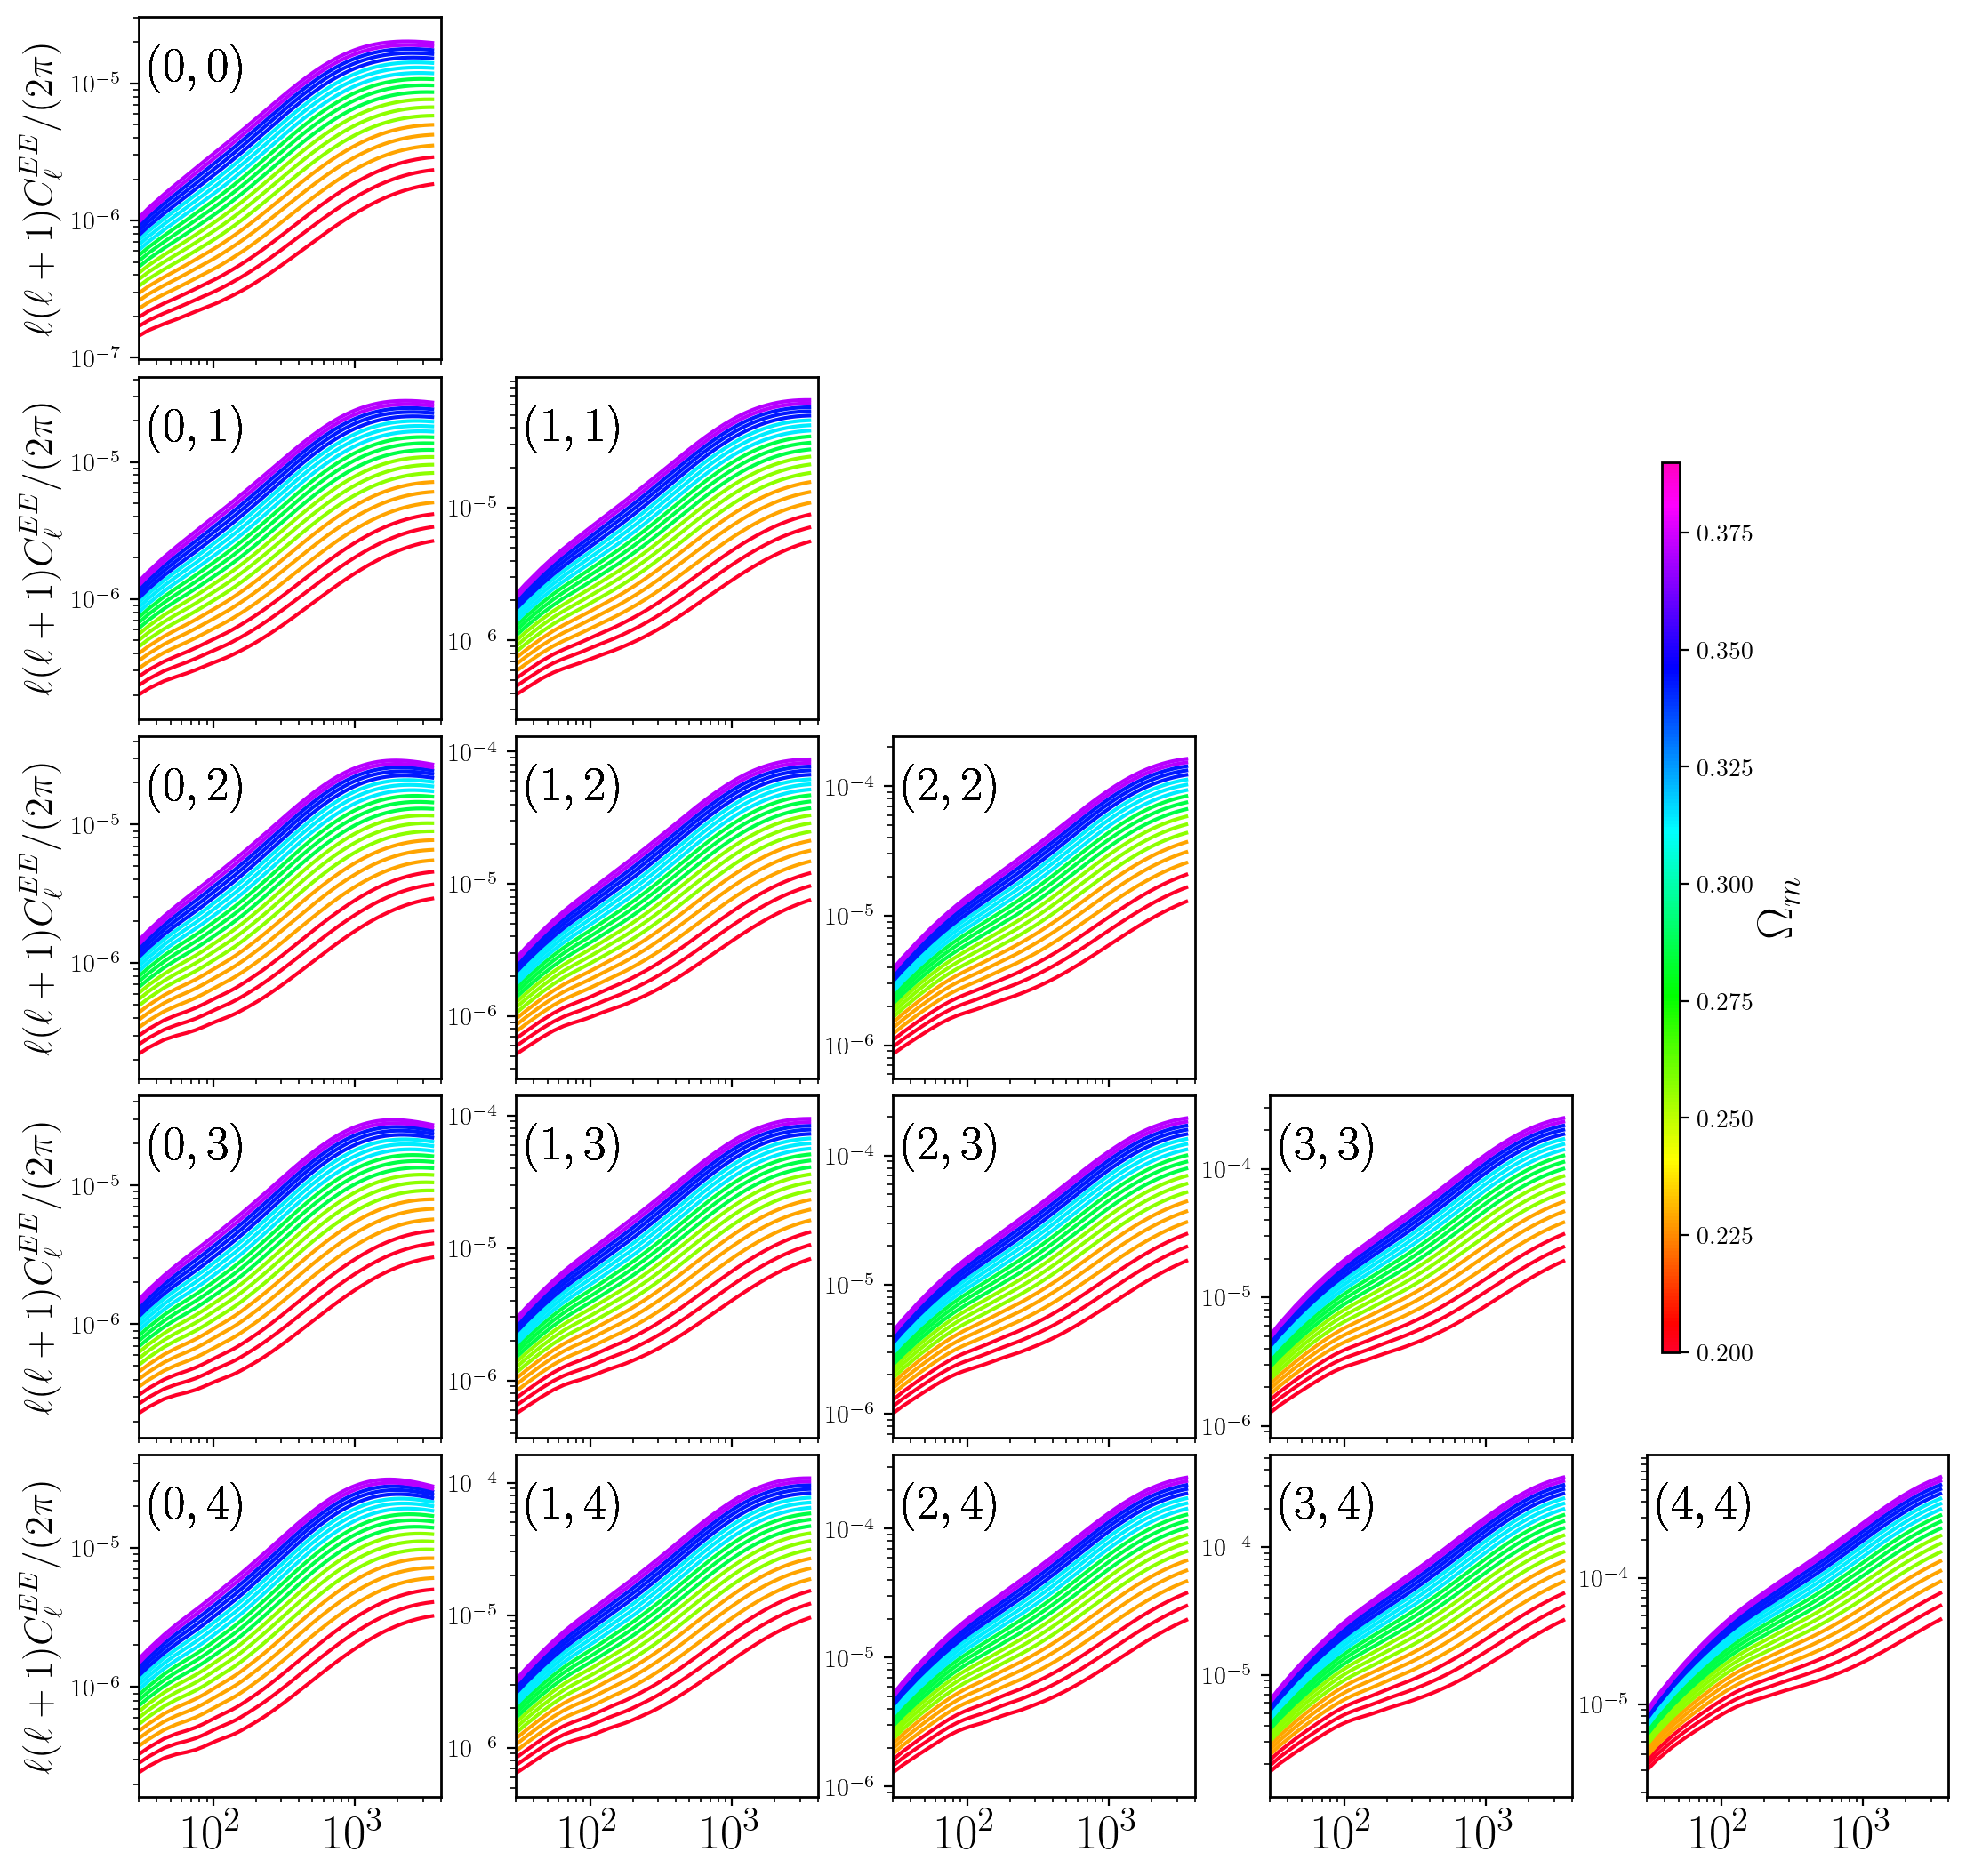

In [87]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(13, 13), sharex=True, sharey=False, gridspec_kw = {'wspace': 0.25, 'hspace': 0.05})

ell = np.arange(25.,3500.,10.) # Make sure arange are with float numbers (otherwise there are aliasing problems)
cosmo = np.arange(0.2,0.4,0.01)
NUM_COLORS = len(cosmo)

cm = plt.get_cmap('gist_rainbow')
ncosmo=0

cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(cosmo[0], cosmo[len(cosmo)-1]), cmap='gist_rainbow'),
             ax=axes.ravel().tolist(), 
             orientation='vertical',
             aspect=50,
             pad=-0.16,
             shrink=0.5
            )
cb.set_label(label="$\Omega_m$", size=20, weight='bold',labelpad=2)

result = []
for x in cosmo:
    result.append(fCSS(ell, x, omegab, H0, ns, As_1e9, w, w0pwa))

nz=0
for i in range(5):
    for j in range(5):
        if i>j:                
            axes[j,i].axis('off')
        else:
            clmin = []
            clmax = []
            for x in range(len(cosmo)):
                CSS = result[x]
                clmin.append(np.min( ell*(ell + 1)*CSS[:,nz]/(2 * 3.1415) ))
                clmax.append(np.max( ell*(ell + 1)*CSS[:,nz]/(2 * 3.1415) ))

            for x in range(len(cosmo)):
                CSS = result[x]
                axes[j,i].set_xlim([30, 4000])
                axes[j,i].set_ylim([np.min(0.75*np.array(clmin)), np.max(1.5*np.array(clmax))])    
                axes[j,i].set_xscale('log')
                axes[j,i].set_yscale('log')
                
                if i == 0:
                    axes[j,i].set_ylabel(r"$\ell (\ell+1) C_{\ell}^{EE}/(2 \pi)$", fontsize=16)
            
                for item in (axes[j,i].get_yticklabels()):
                    item.set_fontsize(10)

                for item in (axes[j,i].get_xticklabels()):
                    item.set_fontsize(20)
                
                axes[j,i].text(0.2, 0.85, 
                               "$(" +  str(i) + "," +  str(j) + ")$", 
                               horizontalalignment='center', 
                               verticalalignment='center',
                               fontsize=20,
                               usetex=True,
                               transform=axes[j,i].transAxes)
    
                
                lines = axes[j,i].plot(ell, ell * (ell + 1) * CSS[:,nz] / (2 * 3.1415), color=cm(x//3*3.0/NUM_COLORS))
            nz=nz+1

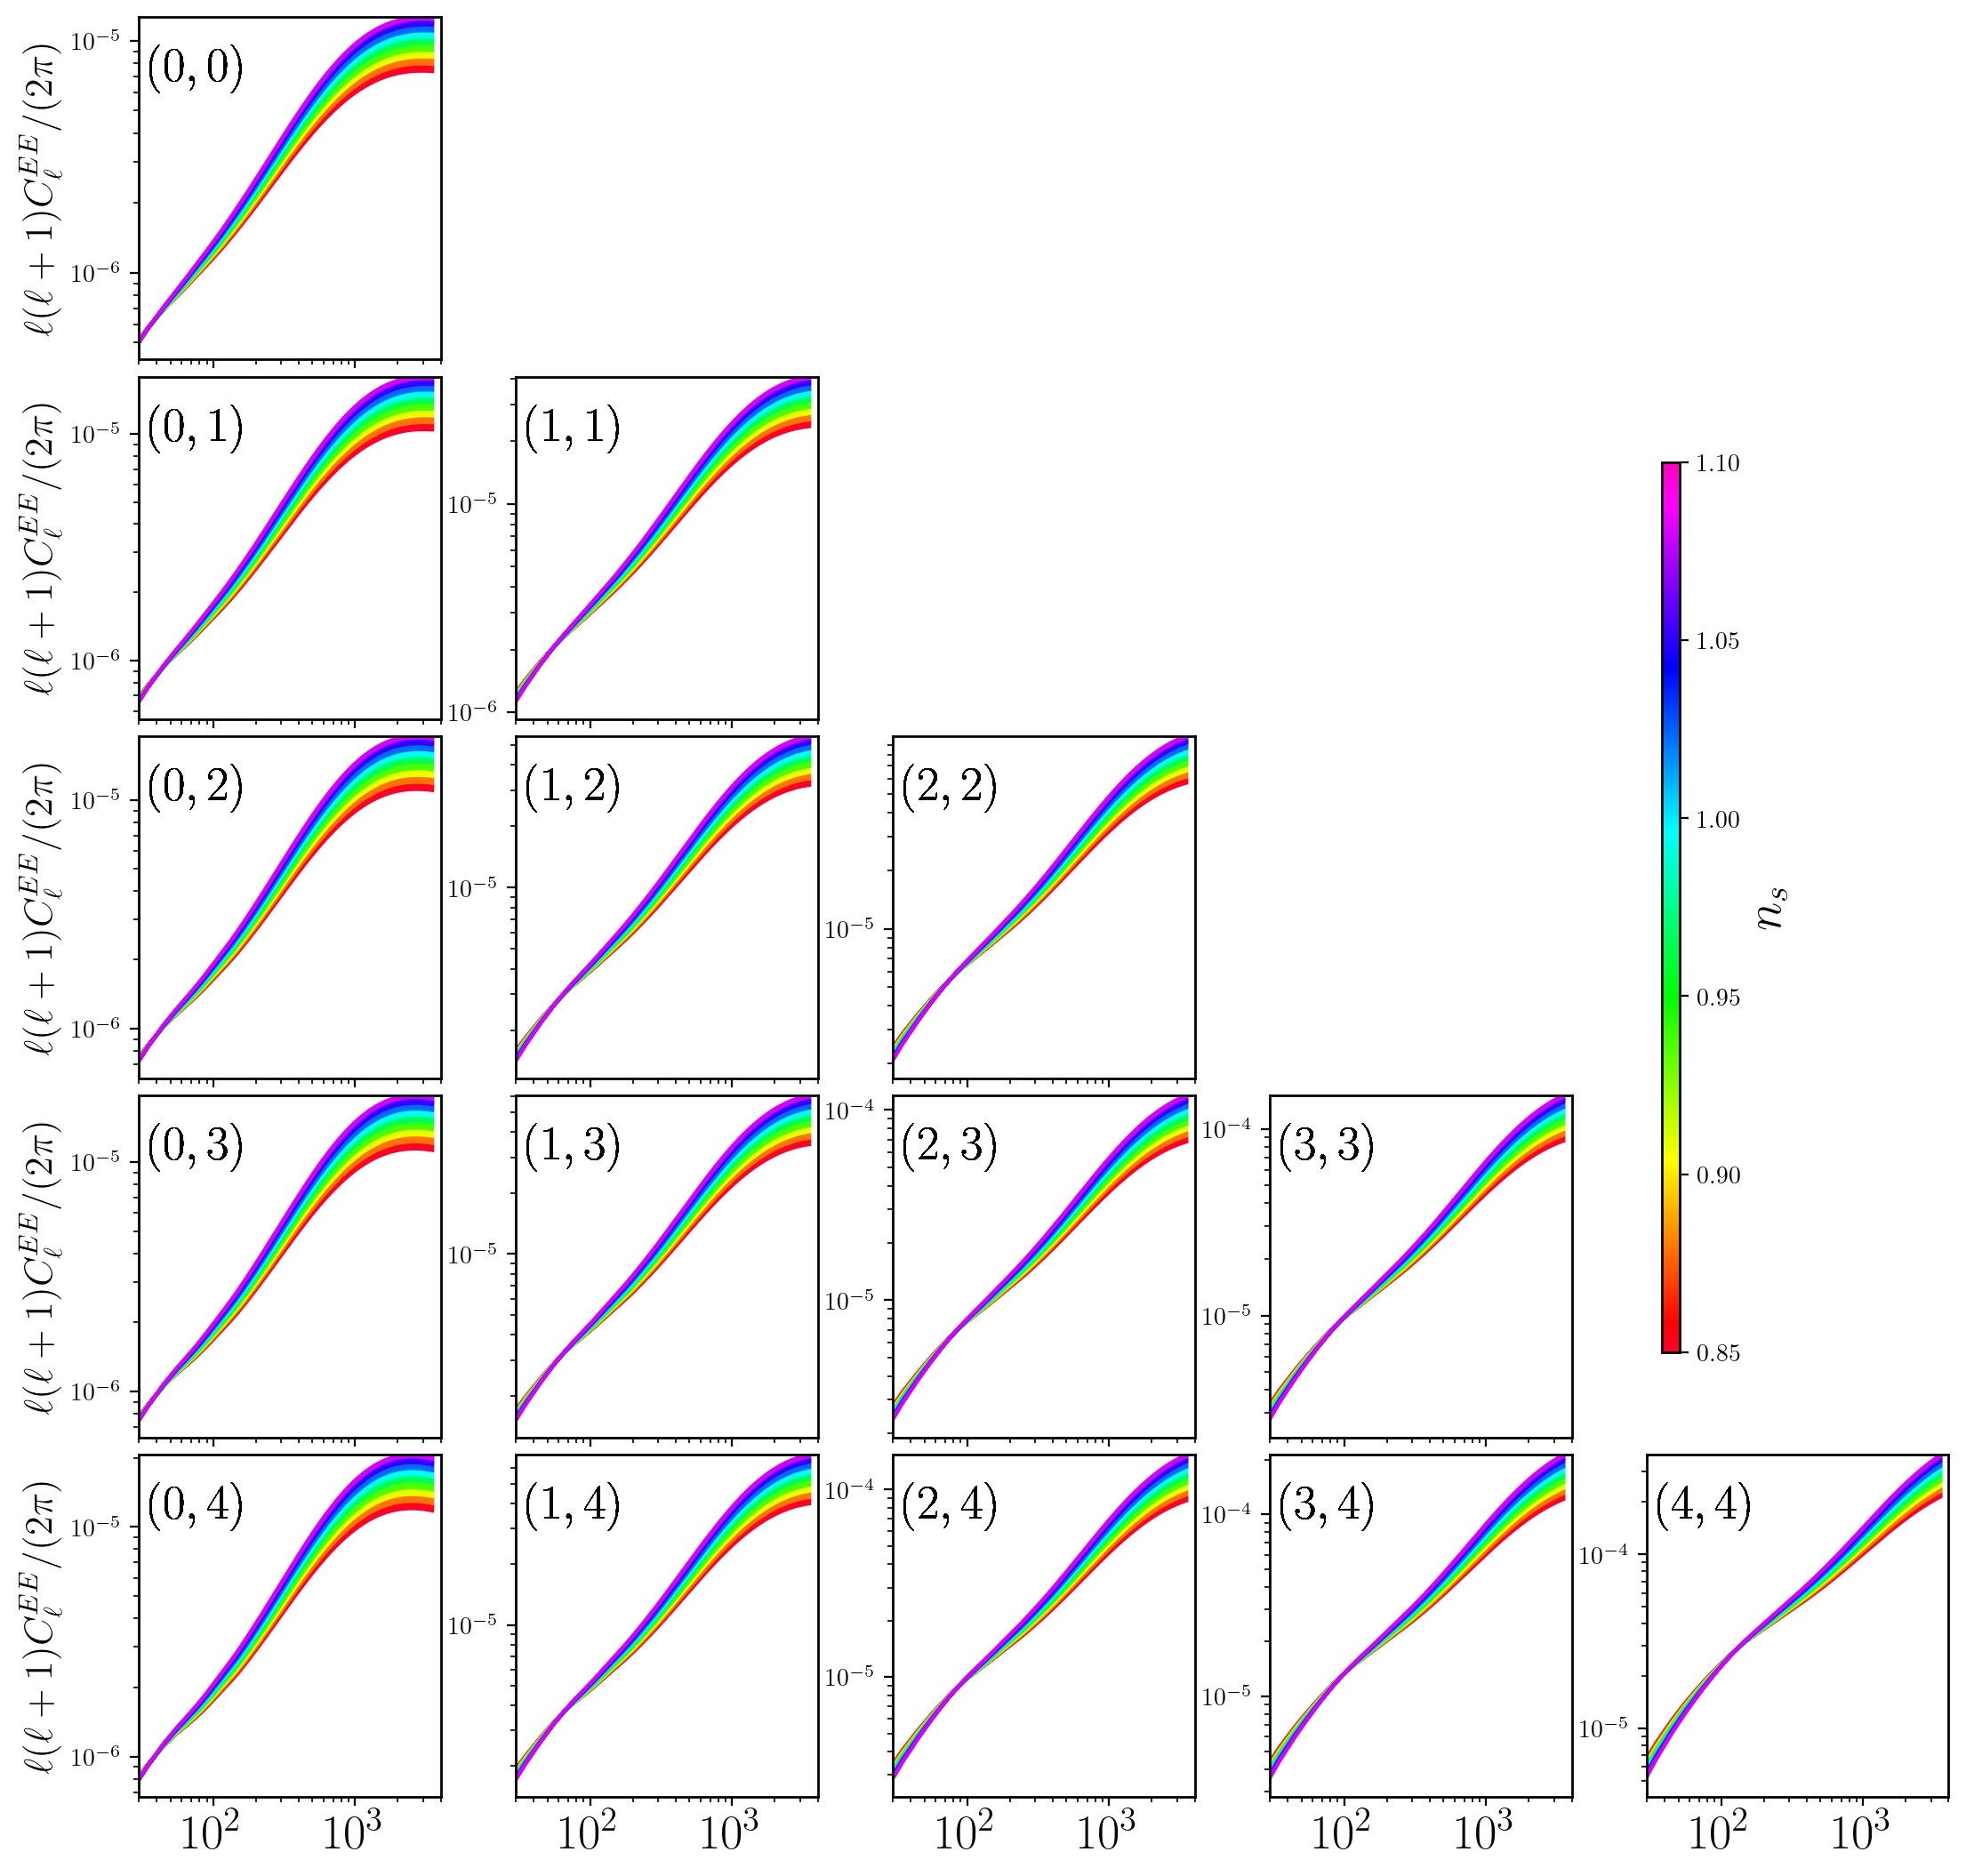

In [88]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(13, 13), sharex=True, sharey=False, gridspec_kw = {'wspace': 0.25, 'hspace': 0.05})

ell = np.arange(25.,3500.,10.) # Make sure arange are with float numbers (otherwise there are aliasing problems)
cosmo = np.arange(0.85,1.1,0.01)
NUM_COLORS = len(cosmo)

cm = plt.get_cmap('gist_rainbow')
ncosmo=0

cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(cosmo[0], cosmo[len(cosmo)-1]), cmap='gist_rainbow'),
             ax=axes.ravel().tolist(), 
             orientation='vertical',
             aspect=50,
             pad=-0.16,
             shrink=0.5
            )
cb.set_label(label="$n_s$", size=20, weight='bold',labelpad=2)

result = []
for x in cosmo:
    result.append(fCSS(ell, omegam, omegab, H0, x, As_1e9, w, w0pwa))

nz=0
for i in range(5):
    for j in range(5):
        if i>j:                
            axes[j,i].axis('off')
        else:
            clmin = []
            clmax = []
            for x in range(len(cosmo)):
                CSS = result[x]
                clmin.append(np.min( ell*(ell + 1)*CSS[:,nz]/(2 * 3.1415) ))
                clmax.append(np.max( ell*(ell + 1)*CSS[:,nz]/(2 * 3.1415) ))

            for x in range(len(cosmo)):
                CSS = result[x]
                axes[j,i].set_xlim([30, 4000])
                axes[j,i].set_ylim([np.min(np.array(clmin)), np.max(np.array(clmax))])    
                axes[j,i].set_xscale('log')
                axes[j,i].set_yscale('log')
                
                if i == 0:
                    axes[j,i].set_ylabel(r"$\ell (\ell+1) C_{\ell}^{EE}/(2 \pi)$", fontsize=16)
            
                for item in (axes[j,i].get_yticklabels()):
                    item.set_fontsize(10)

                for item in (axes[j,i].get_xticklabels()):
                    item.set_fontsize(20)
                
                axes[j,i].text(0.2, 0.85, 
                               "$(" +  str(i) + "," +  str(j) + ")$", 
                               horizontalalignment='center', 
                               verticalalignment='center',
                               fontsize=20,
                               usetex=True,
                               transform=axes[j,i].transAxes)
    
                
                lines = axes[j,i].plot(ell, ell * (ell + 1) * CSS[:,nz] / (2 * 3.1415), color=cm(x//3*3.0/NUM_COLORS))
            nz=nz+1